In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("stevenpeutz/misinformation-fake-news-text-dataset-79k")

print("Path to dataset files:", path)

100%|██████████| 84.6M/84.6M [00:04<00:00, 18.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/stevenpeutz/misinformation-fake-news-text-dataset-79k/versions/2


In [3]:
df_true=pd.read_csv(path+'/DataSet_Misinfo_TRUE.csv')
df_fake=pd.read_csv(path+'/DataSet_Misinfo_FAKE.csv')

In [4]:
df_true['label']=1
df_true=df_true.drop('Unnamed: 0',axis=1)
df_true.head()

,text,label
0,The head of a conservative Republican faction ...,1
1,Transgender people will be allowed for the fir...,1
2,The special counsel investigation of links bet...,1
3,Trump campaign adviser George Papadopoulos tol...,1
4,President Donald Trump called on the U.S. Post...,1


In [5]:
df_fake['label']=0
df_fake=df_fake.drop('Unnamed: 0',axis=1)
df_fake.head()

,text,label
0,Donald Trump just couldn t wish all Americans ...,0
1,House Intelligence Committee Chairman Devin Nu...,0
2,"On Friday, it was revealed that former Milwauk...",0
3,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis used his annual Christmas Day mes...,0


In [6]:
df=pd.concat([df_true,df_fake],ignore_index=True)
df.head()

,text,label
0,The head of a conservative Republican faction ...,1
1,Transgender people will be allowed for the fir...,1
2,The special counsel investigation of links bet...,1
3,Trump campaign adviser George Papadopoulos tol...,1
4,President Donald Trump called on the U.S. Post...,1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78617 entries, 0 to 78616
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    78588 non-null  object
 1   label   78617 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.2+ MB


In [8]:
df=df.dropna(how="any")
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78588 entries, 0 to 78616
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    78588 non-null  object
 1   label   78588 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ MB


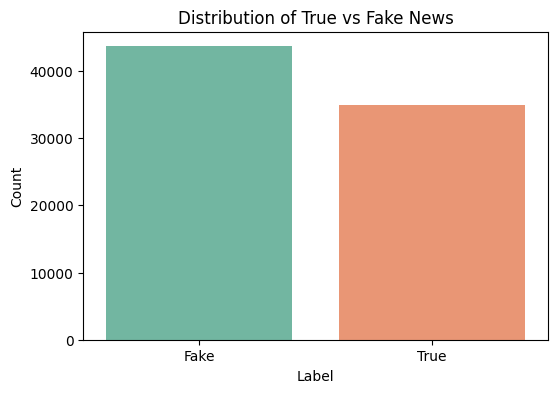

In [9]:
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df, palette='Set2')
plt.title('Distribution of True vs Fake News')
plt.xticks([0, 1], ['Fake', 'True'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [ ]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
nltk.download('punkt', download_dir='/content/nltk_data')



[nltk_data] Downloading package punkt to /content/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
nltk.data.path.append('/content/nltk_data')


In [ ]:
# import spacy
# from sklearn.feature_extraction.text import TfidfVectorizer
# import pandas as pd

# # Load English language model
# nlp = spacy.load("en_core_web_sm")

# # Define preprocessing function
# def preprocess_text(text):
#     doc = nlp(text, disable=["parser", "ner"])
#     tokens = [token.text.lower() for token in doc if not token.is_stop and len(token.text) > 1]
#     return " ".join(tokens)

# # Apply preprocessing
# df["text"] = df["text"].apply(preprocess_text)

# # Vectorize text
# vectorizer = TfidfVectorizer()
# X = vectorizer.fit_transform(df["text"])

# y = df["label"].values

In [10]:
import re
from collections import Counter

def tokenize_text(text):
    text = text.lower()
    tokens = re.findall(r'\b\w+\b', text)
    stop_words = {"the", "and", "a", "is", "in", "it", "of", "to"}
    tokens = [t for t in tokens if t not in stop_words and len(t) > 1]
    return tokens

# Apply tokenization
X = df["text"].apply(tokenize_text).values.tolist()

In [11]:
import gensim

EMBEDDING_DIM = 100

w2v_model = gensim.models.Word2Vec(
    sentences=X,
    vector_size=EMBEDDING_DIM,
    window=5,
    min_count=1,
    workers=4
)

In [12]:
len(w2v_model.wv.index_to_key)

240981

In [13]:
w2v_model.wv["war"]

array([ 3.185018  , -1.6890612 ,  2.1304097 ,  0.33408153, -3.4756    ,
       -2.2373915 ,  3.0495548 ,  0.254257  , -0.02249726,  0.82633185,
        4.009998  ,  3.9246638 , -2.4553506 ,  2.0281832 ,  2.4161913 ,
        2.884763  ,  0.13171059, -4.2210927 , -0.6981099 ,  1.9470714 ,
       -0.7123041 , -1.9709795 , -2.6075869 ,  1.92905   ,  2.1215084 ,
       -1.2191925 , -2.8434148 ,  0.931857  , -3.554801  ,  3.600389  ,
       -1.0103352 ,  0.0822624 , -1.011624  ,  1.8507814 ,  2.3936183 ,
        3.427245  ,  0.6823266 ,  0.37572408, -2.4822388 , -6.8364506 ,
        3.7907033 , -0.3452501 ,  1.2578499 ,  0.29610655,  3.1329672 ,
        0.2785667 , -1.2158664 ,  2.0940447 ,  0.5622373 ,  1.3490541 ,
       -3.8940961 ,  0.7760379 ,  0.54477143,  1.73749   , -1.0465297 ,
       -1.5592668 ,  3.2198162 ,  2.375879  , -3.8571126 , -1.8759894 ,
       -3.128323  , -0.705598  ,  0.5361208 , -1.3105658 ,  2.28159   ,
        0.6248172 , -2.0418918 , -4.990576  ,  1.9082243 , -2.00

In [14]:
w2v_model.wv.most_similar("pandemic")

[('poisoning', 0.6444534063339233),
 ('epidemics', 0.6389155983924866),
 ('infectious', 0.6326056718826294),
 ('waterborne', 0.6309366822242737),
 ('preventable', 0.6143419742584229),
 ('mumps', 0.5959166288375854),
 ('induced', 0.5958805680274963),
 ('outbreaks', 0.5870922803878784),
 ('neurotoxic', 0.5800142288208008),
 ('displacement', 0.5781852602958679)]

In [15]:
w2v_model.wv.most_similar("japan")

[('china', 0.7792277336120605),
 ('india', 0.7412481904029846),
 ('tokyo', 0.6988884806632996),
 ('beijing', 0.6908328533172607),
 ('philippines', 0.681323230266571),
 ('asia', 0.6605242490768433),
 ('norway', 0.6562319993972778),
 ('pyongyang', 0.6508187651634216),
 ('australia', 0.6285867094993591),
 ('japanese', 0.6216066479682922)]

In [16]:
w2v_model.wv.most_similar("innovation")

[('entrepreneurship', 0.7733542919158936),
 ('sustainable', 0.7563331127166748),
 ('innovative', 0.7503958344459534),
 ('development', 0.7470537424087524),
 ('resource', 0.7272653579711914),
 ('technology', 0.7166914939880371),
 ('technological', 0.7162104249000549),
 ('partnerships', 0.6577810049057007),
 ('efficiency', 0.6513648629188538),
 ('architecture', 0.6511150598526001)]

In [17]:
w2v_model.wv.most_similar(positive=["beatles","stones", "england"])

[('castle', 0.7109895944595337),
 ('café', 0.7054446339607239),
 ('antique', 0.6923287510871887),
 ('tavern', 0.691148042678833),
 ('dolls', 0.688064694404602),
 ('piano', 0.6863483190536499),
 ('drummer', 0.6862443089485168),
 ('velvet', 0.6848033666610718),
 ('oak', 0.6820524334907532),
 ('plymouth', 0.6761486530303955)]

In [18]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)

In [19]:
X[0][:10]

[462, 407, 98, 7014, 228, 23, 893, 14, 296, 2]

In [20]:
word_index = tokenizer.word_index
for word, num in word_index.items():
    print(f"{word} -> {num}")
    if num == 10:
        break

that -> 1
for -> 2
on -> 3
he -> 4
with -> 5
was -> 6
as -> 7
said -> 8
trump -> 9
by -> 10


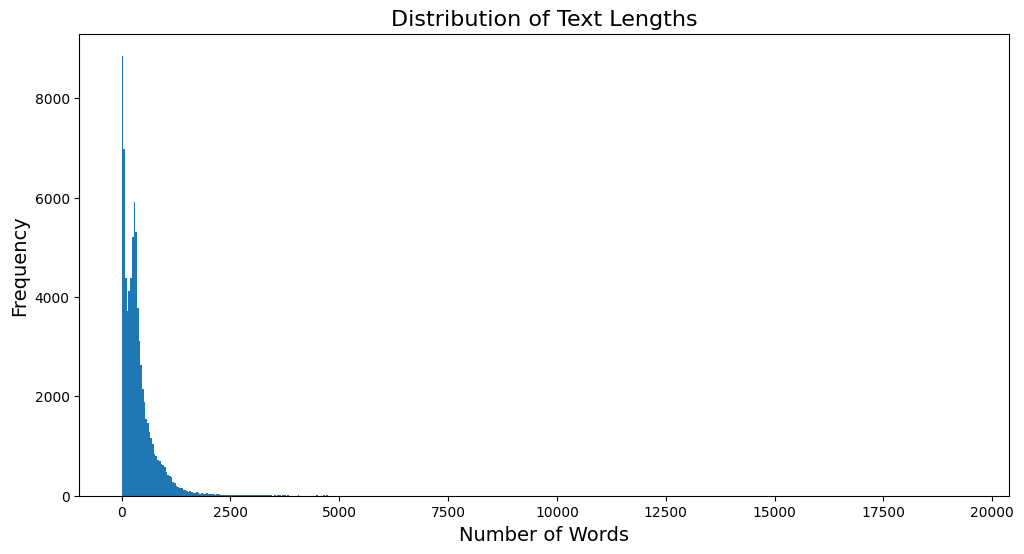

In [21]:
plt.figure(figsize=(12, 6))
plt.title("Distribution of Text Lengths", fontsize=16)
plt.xlabel("Number of Words", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.hist([len(x) for x in X], bins=500)
plt.show()

In [22]:
nos = np.array([len(x) for x in X])
len(nos[nos  < 1000])

73616

In [23]:
maxlen = 1000
X = pad_sequences(X, maxlen=maxlen)
len(X[0])

1000

In [24]:
vocab_size = len(tokenizer.word_index) + 1
def get_weight_matrix(model, vocab):
    vocab_size = len(vocab) + 1
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

**Apply LSTM**

In [25]:
embedding_vectors = get_weight_matrix(w2v_model.wv, word_index)
model = Sequential()
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

del embedding_vectors

In [26]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │      24,098,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,098,200 (91.93 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 24,098,200 (91.93 MB)

In [30]:
y = df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
model.fit(X_train, y_train, validation_split=0.3, epochs=1)

1376/1376 ━━━━━━━━━━━━━━━━━━━━ 2030s 1s/step - acc: 0.9102 - loss: 0.2326 - val_acc: 0.9396 - val_loss: 0.1518


In [33]:
y_pred = (model.predict(X_test) >= 0.5).astype("int")

492/492 ━━━━━━━━━━━━━━━━━━━━ 239s 486ms/step


In [35]:
accuracy_score(y_test, y_pred)

0.9389235271663061

In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      8707
           1       0.94      0.92      0.93      7011

    accuracy                           0.94     15718
   macro avg       0.94      0.94      0.94     15718
weighted avg       0.94      0.94      0.94     15718



**Apply GRU**

In [38]:
from tensorflow.keras.layers import GRU
embedding_vectors = get_weight_matrix(w2v_model.wv, word_index)
# Define the GRU model
model_gru = Sequential()
model_gru.add(Embedding(vocab_size,
                        output_dim=EMBEDDING_DIM,
                        weights=[embedding_vectors],
                        input_length=maxlen,
                        trainable=False))  # Use pre-trained embeddings
model_gru.add(GRU(units=128))  # Add a GRU layer with 128 units
model_gru.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
model_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])


In [39]:
model_gru.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │      24,098,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,098,200 (91.93 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 24,098,200 (91.93 MB)

In [41]:

# Train the GRU model
history_gru = model_gru.fit(X_train, y_train,
                            validation_split=0.3,
                            epochs=1,
                            batch_size=64)

688/688 ━━━━━━━━━━━━━━━━━━━━ 1549s 2s/step - acc: 0.8595 - loss: 0.3189 - val_acc: 0.9505 - val_loss: 0.1322


In [42]:
y_pred_gru = (model_gru.predict(X_test) >= 0.5).astype("int")

492/492 ━━━━━━━━━━━━━━━━━━━━ 118s 239ms/step


In [43]:

# Evaluate GRU model
accuracy_gru = accuracy_score(y_test, y_pred_gru)
print(f"GRU Model Accuracy: {accuracy_gru}")
print(classification_report(y_test, y_pred_gru))

GRU Model Accuracy: 0.9492301819569919
              precision    recall  f1-score   support

           0       0.97      0.94      0.95      8707
           1       0.93      0.96      0.94      7011

    accuracy                           0.95     15718
   macro avg       0.95      0.95      0.95     15718
weighted avg       0.95      0.95      0.95     15718



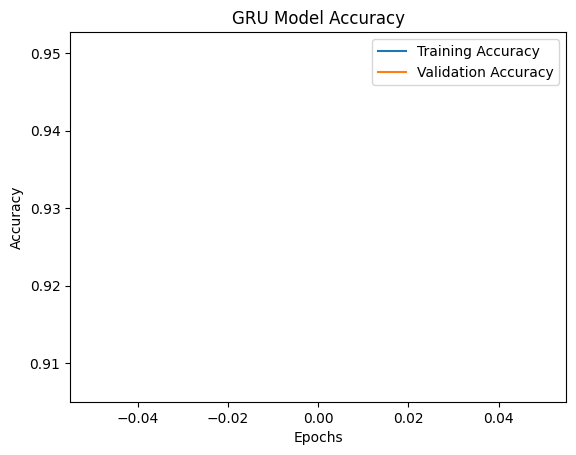

In [44]:
plt.plot(history_gru.history['acc'], label='Training Accuracy')
plt.plot(history_gru.history['val_acc'], label='Validation Accuracy')
plt.title('GRU Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()